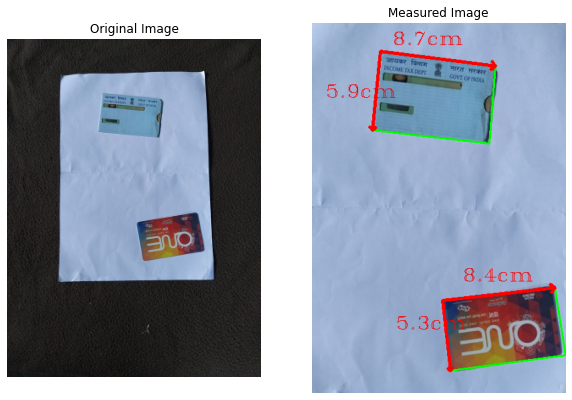

In [7]:
imgPath = '2.jpg'

In [8]:
import cv2
import numpy as np

def getContours(img, cannyThres=[100, 100], showCanny=False, minArea=1000, filter=0, draw=False):
    
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray, (5,5), 1)
    imgCanny = cv2.Canny(imgBlur, cannyThres[0], cannyThres[1])   
    
    kernel = np.ones( (5, 5) )
    imgDial = cv2.dilate(imgCanny, kernel, iterations=3)
    imgThre = cv2.erode(imgDial, kernel, iterations=2) 
    
    if showCanny:
        cv2.imshow('Canny', imgThre)
    
    contours, hierarchy = cv2.findContours(imgThre, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    finalContours = []
    for i in contours:
        area = cv2.contourArea(i)
        if area > minArea:
            peri = cv2.arcLength(i,True) # it finds length of curve
            approx = cv2.approxPolyDP(i,0.02*peri,True) # it finds cornor points  
            bbox = cv2.boundingRect(approx) # it return 4 points x, y, w, h. Here x,y is the top left point
            
            if filter > 0:
                if len(approx) == filter:
                    finalContours.append([len(approx),area,approx,bbox,i])
            else:
                finalContours.append([len(approx),area,approx,bbox,i])

    finalContours = sorted(finalContours,key = lambda x:x[1] ,reverse= True)

    if draw:
        for con in finalContours:
            cv2.drawContours(img,con[4],-1,(0,0,255),3)
            
    return img, finalContours     
            

    
# we do not get points always in correct order (top left as 1, top right as 2, bottom left as 3 & botton right as 4)
def reorder(myPoints):
    #print(myPoints.shape)
    myPointsNew = np.zeros_like(myPoints)
    myPoints = myPoints.reshape((4,2))
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints,axis=1)
    myPointsNew[1]= myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew


def warpImg (img,points,w,h,pad=20):
    # print(points)
    points =reorder(points)
    pts1 = np.float32(points)
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgWarp = cv2.warpPerspective(img,matrix,(w,h))
    imgWarp = imgWarp[pad:imgWarp.shape[0]-pad,pad:imgWarp.shape[1]-pad]
    return imgWarp

def findDis(pts1,pts2):
    return ((pts2[0]-pts1[0])**2 + (pts2[1]-pts1[1])**2)**0.5

def showImage(img, imgName):
    cv2.imshow(f"{imgName}", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [22]:
################################### 
webcam = False
cap = cv2.VideoCapture(0)
cap.set(10, 160) # 10 is id for brightness and 160 is brightness value
cap.set(3, 1920)  # 3 is id for width and 400 is width value
cap.set(4, 1080)  # 4 is id for height and 600 is height value
scale = 2
wP = 210 *scale
hP= 297 *scale
###################################


while True:
    if webcam:
        success, img = cap.read()
        
    else: img = cv2.imread(imgPath)
        
    
    imgContours , conts = getContours(img, minArea=50000, filter=4)
    
    if len(conts) != 0:
        biggest = conts[0][2]
        imgWarp = warpImg(img, biggest, wP, hP)
        imgContours2, conts2 = getContours(imgWarp,
                                           minArea=2000, filter=4,
                                           cannyThres=[50,50], draw = False)
        
        
        
        if len(conts2) != 0:
            for obj in conts2:
                cv2.polylines(imgContours2,[obj[2]],True,(0,255,0),2)
                nPoints = reorder(obj[2])
                
                nW = round((findDis(nPoints[0][0]//scale, nPoints[1][0]//scale)/10), 1)
                nH = round((findDis(nPoints[0][0]//scale, nPoints[2][0]//scale)/10), 1)
                
                cv2.arrowedLine(imgContours2, (nPoints[0][0][0], nPoints[0][0][1]), (nPoints[1][0][0], nPoints[1][0][1]),
                                (0, 0, 255), 3, 8, 0, 0.05)
                cv2.arrowedLine(imgContours2, (nPoints[0][0][0], nPoints[0][0][1]), (nPoints[2][0][0], nPoints[2][0][1]),
                                (0, 0, 255), 3, 8, 0, 0.05)
                
                x, y, w, h = obj[3]
                cv2.putText(imgContours2, f"{nW}cm", (x + 30, y - 10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5,
                            (0, 0, 255), 1)
                cv2.putText(imgContours2, f"{nH}cm", (x - 70, y + h // 2), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5,
                            (0, 0, 255), 1)
        
        cv2.imshow('A4', imgContours2)

    img = cv2.resize(img,(0,0),None,0.5,0.5)
    cv2.imshow('Original', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    break

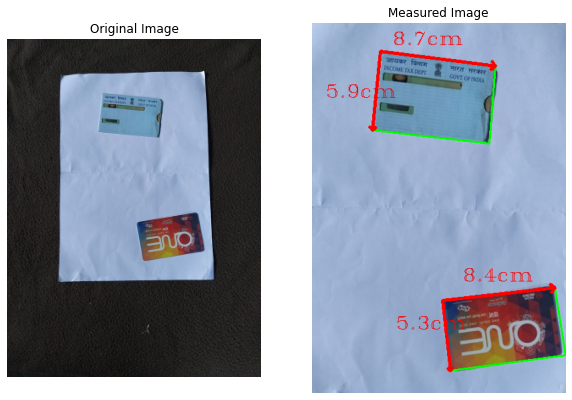

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)
  
# showing image
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.title("Original Image")

fig.add_subplot(1, 2, 2)
  
# showing image
plt.imshow(imgContours2[:,:,::-1])
plt.axis('off')
plt.title("Measured Image")

plt.show()